# View 4D beam density data interactively

$x_3$ = x position at VS34 
$y_3$ = y position at VS34
$x_2$ = position of VT06 slit \
$y_1$ = position of HZ04 slit \
$x_1$ = position of VT04 slit

$$
\begin{aligned}
x &= x_1 \\
y &= y_1 \\
x' &= \frac{x_2 - 0.35 x_1}{s_2 - s_1} \\
y' &= \frac{y_3 - y_1}{s_3 - s_1} \\
w  &= f(x_3, x_2, x_1) \\ 
\end{aligned}
$$

In [92]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [11]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

In [4]:
filename = 'integrated4D_rawgrid_220429190854-scan-xxpy-image-ypdE.npz'
coordfilename = 'slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy'

In [6]:
a4d = np.load(filename)['a4d']

## Coordinate transform

Be careful with signs here...

In [7]:
coord_3d = np.load(coordfilename)  # [X1, X2, Y1]
coord_3d.shape

(3, 33, 33, 32)

In [8]:
x1_grid = coord_3d[0, :, 0, 0]
x2_grid = coord_3d[1, 0, :, 0]
y1_grid = coord_3d[2, 0, 0, :] 

pix2mm = -0.0659  # CHANGE THIS!!!???
y3_grid = pix2mm * np.arange(a4d.shape[3])

# Flip y3 axis (image comes in upside-down)
y3_grid = y3_grid[::-1]
a4d = a4d[:, :, :, ::-1]

Y1, Y3 = np.meshgrid(y1_grid, y3_grid, indexing='ij')
X1 = coord_3d[0, :, :, 0]
X2 = coord_3d[1, :, :, 0]

# Make list, center coordinates. `coords_` has coordinates in raw slit values.
coords_ = [X1, X2, Y1, Y3]
for coord in coords_:
    coord -= np.mean(coord)

In [9]:
# Matrix parameters
a2mm = 1.009  # assume same as first dipole
amp2meter = a2mm * 1e3
rho = 0.3556
GL05 = 0.0
GL06 = 0.0
l1 = 0.0
l2 = 0.0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for 1st and last dipole/screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance

ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=amp2meter)

Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

# Matrix mupltiply to get x' and y'. The negative signs are due to the direction
# of the y-slit being opposite of the beam-frame y dimension. The screen axis is 
# also backwards, but this has been accounted for in the previous cell.
Y = -Y1.copy()
YP = ecalc.calculate_yp(-Y1.ravel(), Y3.ravel(), Mscreen)
YP = YP.reshape(Y.shape)

X = X1.copy()
XP = ecalc.calculate_xp(X1.ravel(), X2.ravel(), Mslit)
XP = XP.reshape(X.shape)

# Make list, center coordinates. `coords` has coordinates in mm, mrad.
coords = [X, XP, Y, YP]
for coord in coords:
    coord -= coord.mean()

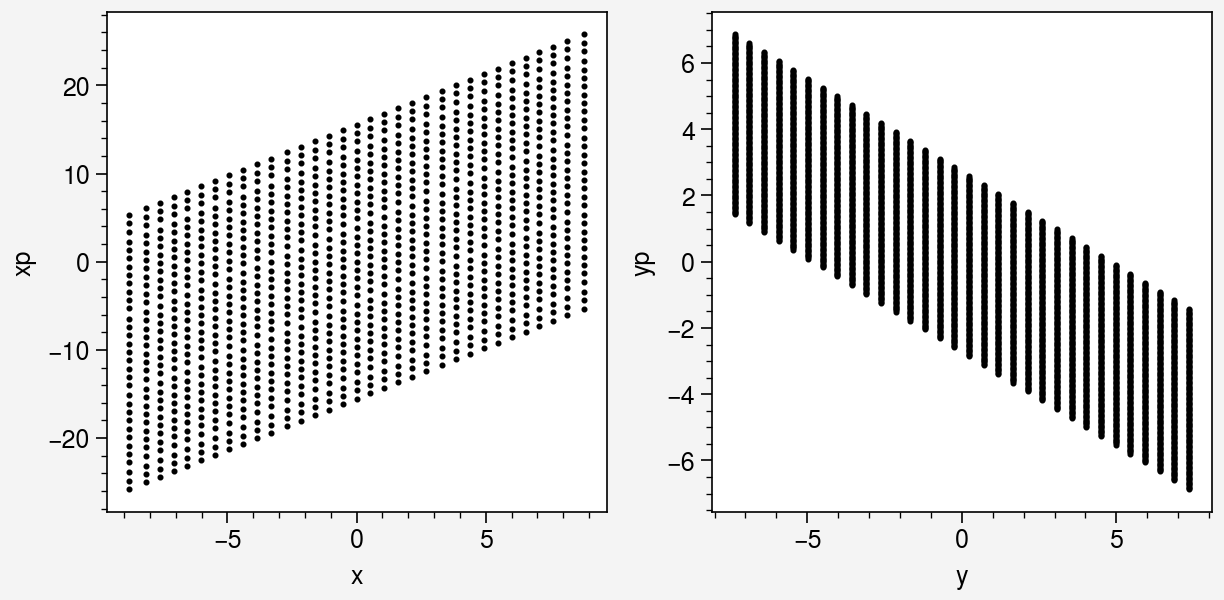

In [32]:
fig, axes = pplt.subplots(ncols=2, share=False)
for ax, U, UP, label in zip(axes, [X, Y], [XP, YP], ['x', 'y']):
    ax.scatter(U.ravel(), UP.ravel(), marker='.', c='black', s=10)
    ax.format(xlabel=label, ylabel=label + 'p')
plt.show()

## Interpolate onto regular grid for x, x'

(Optional) Decrease the resolution of the y3 grid.

In [37]:
# nskip = 2
# a4d_small = a4d[:, :, :, ::nskip]
# y3_grid_small = y3_grid[::nskip]

In [57]:
a4d_small = a4d
y3_grid_small = y3_grid

In [76]:
def plot_log(image, x=None, y=None, density=False, **plot_kws):
    plot_kws.setdefault('colorbar', True)
    fig, axes = pplt.subplots(ncols=2, figwidth=None)
    if x is None:
        x = np.arange(image.shape[0])
    if y is None:
        y = np.arange(image.shape[1])
    for ax, log in zip(axes, [False, True]):
        norm = None
        if log:
            image = np.ma.masked_less_equal(image, 0)
            norm = 'log'
        if density:
            image = image / np.max(image)
        ax.pcolormesh(x, y, image.T, norm=norm, **plot_kws)
    return axes

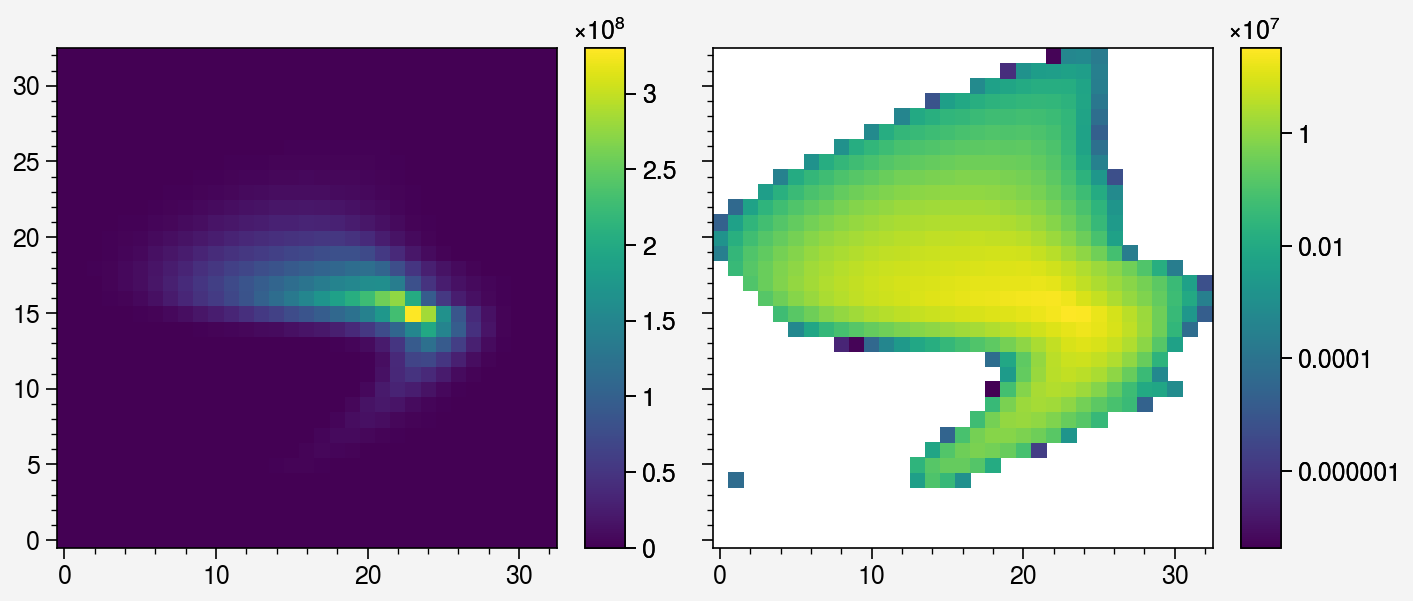

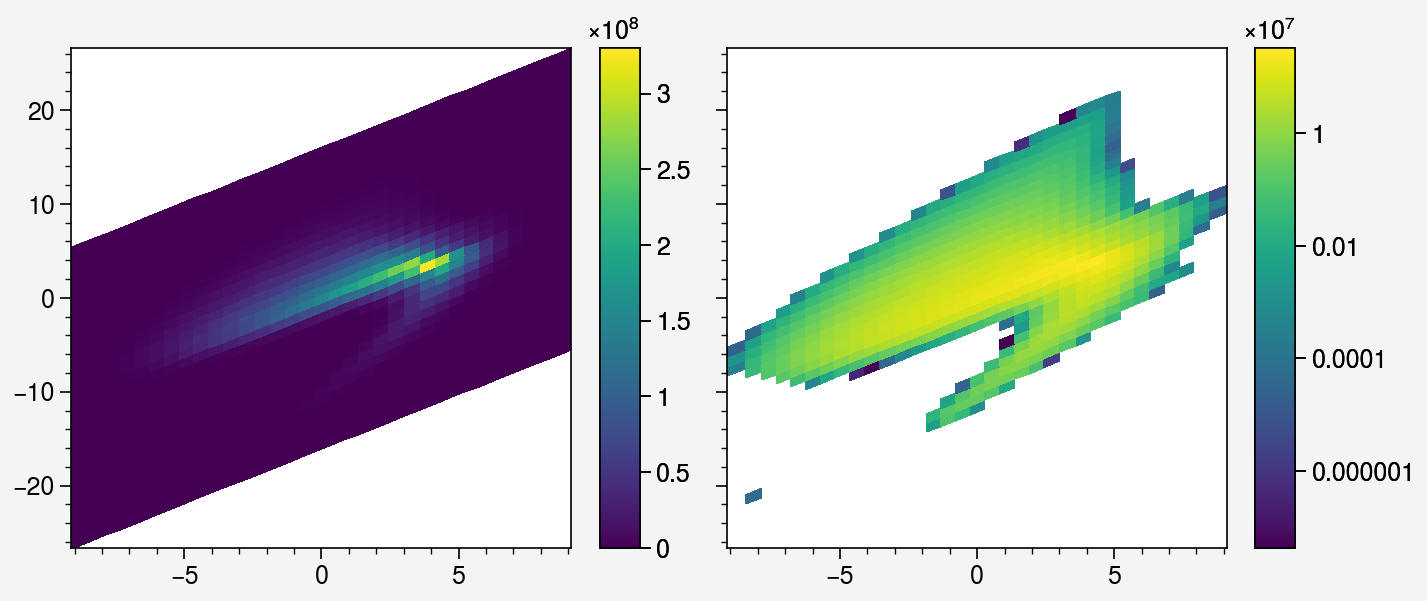

In [81]:
axes = plot_log(utils.project(a4d, [0, 1]))
axes = plot_log(utils.project(a4d, [0, 1]), x=X, y=XP)

## Define interpolation grid

In [86]:
nptsx = 33
nptsxp = 33
# xgv_new = np.linspace(-8, 8, nptsx)  
# xpgv_new = np.linspace(-25, 25, nptsxp) 
xgv_new = np.linspace(X.min(), X.max(), nptsx)
xpgv_new = np.linspace(XP.min(), XP.max(), nptsxp)
Xnew, XPnew = np.meshgrid(xgv_new, xpgv_new, indexing='ij')
newpoints = (Xnew.ravel(), XPnew.ravel())
points = (X.ravel(), XP.ravel())
a4dnew = np.zeros([len(xgv_new), len(xpgv_new), len(y1_grid), len(y3_grid_small)])
print(a4dnew.shape)

(33, 33, 32, 147)


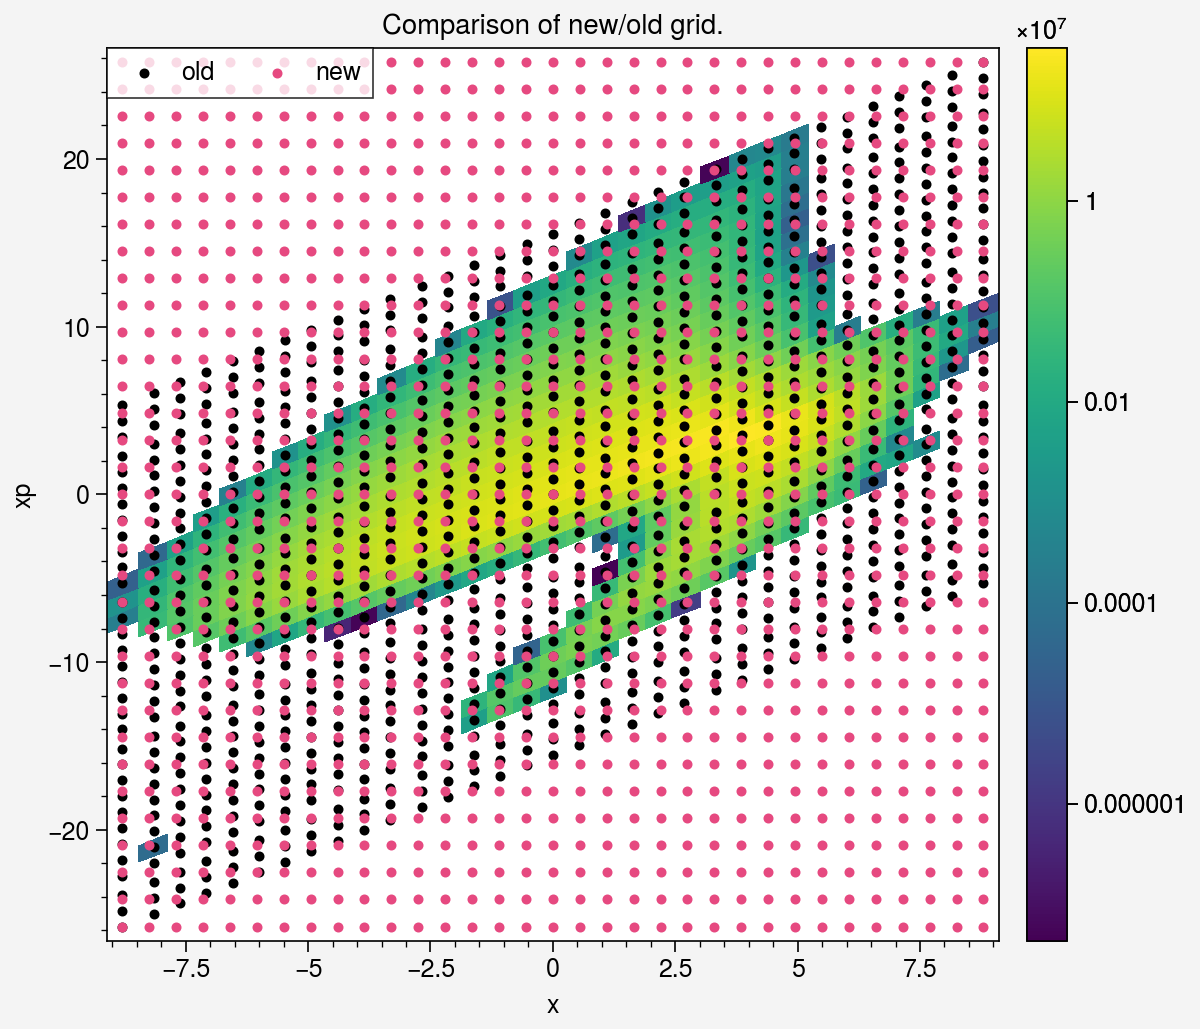

In [121]:
H = project(a4d, axis=[0, 1])

fig, ax = pplt.subplots(figwidth=6)
ax.pcolormesh(X, XP, np.ma.masked_less_equal(H, 0).T, norm='log', colorbar=True)
ax.scatter(X.ravel(), XP.ravel(), marker='.', c='black', label='old')
ax.scatter(Xnew.ravel(), XPnew.ravel(), marker='.', c='pink6', label='new')
ax.legend(loc='upper left')
ax.format(xlabel="x", ylabel="xp", title='Comparison of new/old grid.')
plt.show()

Sanity check: the order of points should match the order of flattened `a4d`.

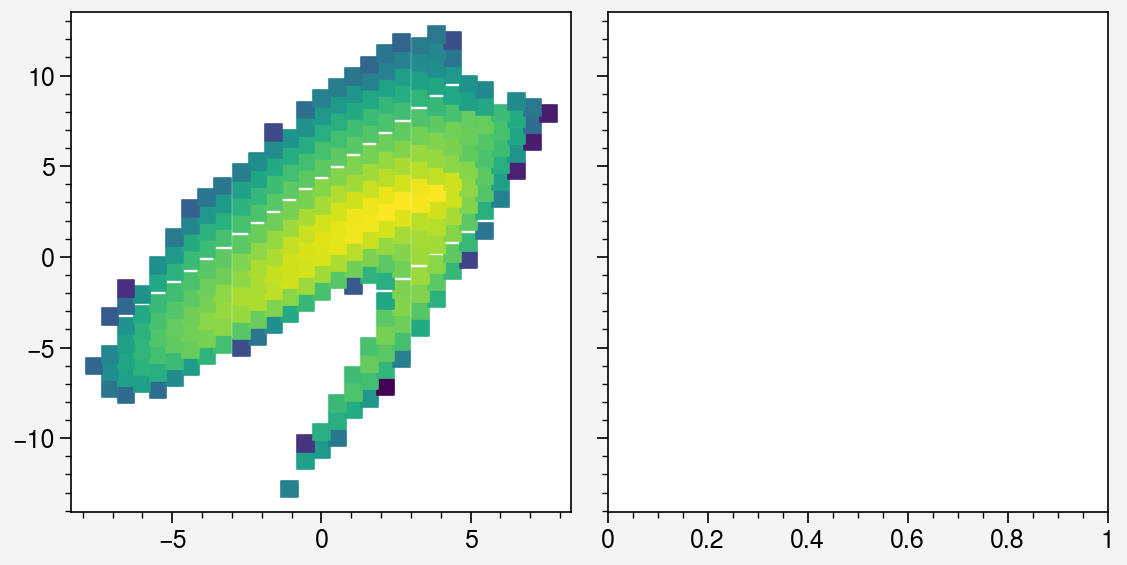

In [145]:
fig, axes = pplt.subplots(ncols=2)
for ax, _points, _arr in zip(axes[:1], [points, newpoints], [a4d, a4dnew]):
    c = _arr[:, :, 14, 57].ravel(order='F')
    c = np.ma.masked_less_equal(c, 0)
    ax.scatter(_points[0], _points[1], marker='s', c=c, norm='log')
plt.show()

In [147]:
for i in trange(len(y1_grid)):
    for j in range(len(y3_grid_small)):
        H = interpolate.griddata(
            points,
            a4d_small[:, :, i, j].ravel(order='F'),
            newpoints,
            fill_value=0.0,
        )
        a4dnew[:, :, i, j] = H.reshape(Xnew.shape)

100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


In [149]:
newcoords = [Xnew, XPnew, Y, YP]
interpgrid = [xgv_new, xpgv_new, Y[:, 0], y3_grid_small]
for grid in interpgrid:
    grid -= grid.mean()

In [160]:
dims = ['x', 'xp', 'y', 'yp']
for dim, grid in zip(dims, interpgrid):
    stepsize = np.mean(np.diff(grid))
    print(f'{dim} dimension')
    print('---------------')
    print(f'Grid points: {len(grid)}')
    print(f'Mean: {np.mean(grid):.2f}')
    print(f'First point: {grid[0]:.2f}')
    print(f'Step size: {stepsize:.2f}')
    print()

x dimension
---------------
Grid points: 33
Mean: -0.00
First point: -8.80
Step size: 0.55

xp dimension
---------------
Grid points: 33
Mean: -0.00
First point: -25.77
Step size: 1.61

y dimension
---------------
Grid points: 32
Mean: -0.00
First point: 7.35
Step size: -0.47

yp dimension
---------------
Grid points: 147
Mean: -0.00
First point: -4.81
Step size: 0.07



## Save data
In convenient format for 4D MENT

In [162]:
# Save rectangular grid info in separate header file.
headername = 'header_' + filename.split('.')[0].split('_')[-1] + '.txt'

# Start a file
fid = open(headername,'w')
header = '#dim,nbins,center,start,stepsize\n'
fid.write(header)
for i in range(len(dims)):
    line = '%s,%i,%6.3f,%6.3f,%6.3f\n'%(dims[i],
                                        len(interpgrid[i]),
                                        interpgrid[i].mean(),
                                        interpgrid[i][0],
                                        stepsize)
    fid.write(line)
fid.close()

In [163]:
a4dnew.shape

(33, 33, 32, 147)

### Histogram saved as binary array

In [166]:
savename = 'pdf_' + filename.split('.')[0].split('_')[-1] + '.dat'
dtype = np.float32 # float 32 should have 7 decimal precision, 16 only has 3)

start_time = time.time()
#pdfmap = np.zeros(tuple(nbins),dtype=dtype)
pdfmap = np.memmap(savename,dtype=dtype,mode = 'w+',shape=np.shape(a4dnew))

pdfmap[:] = a4dnew[:]

# check for overflow (doesn't work for float-type after interpolation - there are 0-values)
# if pdfmap.min() < 0:
#     print('Overflow; max bin value %i has been reached'%(pdfmap.max()))

# -- save array 
#np.savetxt(savename,pdfmap,fmt='%i',header=header)
#savemap = np.memmap(savename,dtype=dtype,mode = 'w+',shape=tuple(nbins))
#savemap[:] = pdfmap[:]
#del savemap
del pdfmap

print('elapsed time %.3f sec'%((time.time() - start_time)))

elapsed time 0.068 sec
